## Basic import

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from utils import folder_utils

## Basic function

In [3]:

# Example usage
country = "GB"
data_folder = "data"
data_read_category = "raw_data"
data_test_category = "test_data"
data_save_category = "processed_data"
output_folder = "ASOS_DATA"

In [4]:
def get_year_from_filename(filename):
    # extract year from filename
    # filename = "GB_merged_ASOS_1979.csv"
    parts = filename.split("_")
    return parts[3]

In [5]:
def get_asos_year_file_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    csv_files = [
        f
        for f in os.listdir(input_folder_path)
        if f.endswith(".csv") and "_merged_ASOS_" in f
    ]

    # sort by year
    csv_files.sort(key=lambda x: get_year_from_filename(x))

    return [
        os.path.join(input_folder_path, csv_file) for csv_file in csv_files
    ]  # return the full path

In [6]:
def csv_to_nc4(merged_csv_path,year, country, data_folder, data_category, output_folder):
    """Convert the merged CSV file to netCDF4 format by year."""
    df = pd.read_csv(merged_csv_path)
    ds_in = xr.Dataset.from_dataframe(df.set_index(['latitude', 'longitude', 'time']))
    ds_in = ds_in.sel(latitude=slice(50, 58), longitude=slice(-6, 2))
    ddeg_out_lat = 0.25
    ddeg_out_lon = 0.125
    regridded_ds = regrid(ds_in, ddeg_out_lat, ddeg_out_lon, method="bilinear", reuse_weights=False)

    output_directory = folder_utils.find_folder(country,data_folder,data_category,output_folder)
    output_filename = f"{country}_ASOS_regird_{year}.nc"
    output_path = os.path.join(output_directory, output_filename)
    regridded_ds.to_netcdf(output_path)
    print(f"{output_filename} done!")

In [7]:
def get_year(start_year, end_year):
    # start_year = 1979
    # end_year = 2023
    year_list = list(range(start_year, end_year + 1))

    # Convert the integer list to a string list
    year_str_list = [str(year) for year in year_list]

    return year_str_list

## Test example

In [8]:
year_list = get_year(start_year=1979, end_year=2023)

In [9]:
csv_paths = get_asos_year_file_list(
    country, data_folder, data_save_category, output_folder
)

In [37]:
csv_paths

['/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1979.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1980.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1981.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1982.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1983.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1984.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1985.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakc

In [ ]:
# csv_to_nc4(csv_path, year, country, data_folder, data_save_category, output_folder)

In [43]:
"""Convert the merged CSV file to netCDF4 format by year."""
df = pd.read_csv(csv_paths[25])


In [44]:
df

latitude  longitude                 time    t2m
0        57.2049    -2.2053  2004-01-01 00:00:00  276.0
1        57.2049    -2.2053  2004-01-01 01:00:00  276.0
2        57.2049    -2.2053  2004-01-01 02:00:00  276.5
3        57.2049    -2.2053  2004-01-01 03:00:00  276.8
4        57.2049    -2.2053  2004-01-01 04:00:00  277.3
...          ...        ...                  ...    ...
550074   51.0063    -2.6428  2004-12-31 19:00:00  281.5
550075   51.0063    -2.6428  2004-12-31 20:00:00  280.9
550076   51.0063    -2.6428  2004-12-31 21:00:00  281.5
550077   51.0063    -2.6428  2004-12-31 22:00:00  281.0
550078   51.0063    -2.6428  2004-12-31 23:00:00  281.5

[550079 rows x 4 columns]

In [46]:
def filter_data(df):
    """
    Filter data by deleting rows with missing values and wrong values
    """
    # Delete rows with missing values
    df = df.dropna()
   # Convert to datetime
    df["time"] = pd.to_datetime(df["time"])  # Convert to datetime

    # If the time is not a whole hour, delete the row
    is_whole_hour = (df["time"].dt.minute == 0) & (df["time"].dt.second == 0)
    not_null = df["time"].notnull()
    latitude_condition = (df["latitude"] >= 50) & (df["latitude"] <= 58)
    longitude_condition = (df["longitude"] >= -6) & (df["longitude"] <= 2)
    # Combine all conditions
    combined_condition = (
        is_whole_hour & not_null & latitude_condition & longitude_condition
    )

    filtered_df = df[combined_condition]

    return filtered_df


In [47]:
df = filter_data(df)
df

/var/folders/tt/fs_l1by51m30s907pzxq6gf40000gp/T/ipykernel_23224/2189851267.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])  # Convert to datetime


latitude  longitude                time    t2m
0        57.2049    -2.2053 2004-01-01 00:00:00  276.0
1        57.2049    -2.2053 2004-01-01 01:00:00  276.0
2        57.2049    -2.2053 2004-01-01 02:00:00  276.5
3        57.2049    -2.2053 2004-01-01 03:00:00  276.8
4        57.2049    -2.2053 2004-01-01 04:00:00  277.3
...          ...        ...                 ...    ...
550074   51.0063    -2.6428 2004-12-31 19:00:00  281.5
550075   51.0063    -2.6428 2004-12-31 20:00:00  280.9
550076   51.0063    -2.6428 2004-12-31 21:00:00  281.5
550077   51.0063    -2.6428 2004-12-31 22:00:00  281.0
550078   51.0063    -2.6428 2004-12-31 23:00:00  281.5

[538051 rows x 4 columns]

In [62]:
ds_in = xr.Dataset.from_dataframe(df.set_index(['latitude', 'longitude', 'time']))

# 调整维度顺序，并更改数据类型
ds_adjusted = ds_in.transpose("time", "latitude", "longitude")
ds_adjusted["t2m"] = ds_adjusted["t2m"].astype("float32")

print(ds_adjusted)


<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 80, time: 8784)
Coordinates:
  * latitude   (latitude) float64 50.08 50.42 50.44 50.74 ... 57.65 57.71 57.82
  * longitude  (longitude) float64 -5.873 -5.686 -5.257 ... 1.3 1.346 1.357
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan 282.3 ... nan nan nan


In [67]:
a = np.asarray(ds_adjusted['t2m'])

In [69]:
a.shape

(8784, 80, 80)

In [74]:
a[3][0]

array([  nan,   nan, 281.8,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan],
      dtype=float32)

## UK_background

### Modification from gstools

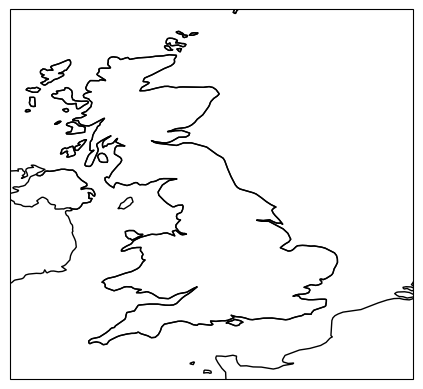

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import shapereader

# 下载简化的英国边界 shapefile
shpfile = shapereader.natural_earth("50m", "cultural", "admin_0_countries")

# 使用 GeoPandas 读取 shapefile
gdf = gpd.read_file(shpfile)
# print(gdf.columns)

# 选择英国的边界
uk_border = gdf[gdf["ADMIN"] == "United Kingdom"]


# 保存英国边界为 GeoJSON 文件
uk_border.to_file("uk_border.geojson", driver="GeoJSON")

# 或者保存为 Shapefile 文件
uk_border.to_file("uk_border.shp")


# 创建地图和投影
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_geometries(uk_border.geometry, crs=ccrs.PlateCarree(), edgecolor="black", facecolor="none")

# 设置地图属性
ax.coastlines(resolution="50m")
ax.set_extent([-8, 4, 49, 60], crs=ccrs.PlateCarree())  # 设置地图显示范围（经度、纬度）

# 显示地图
plt.show()


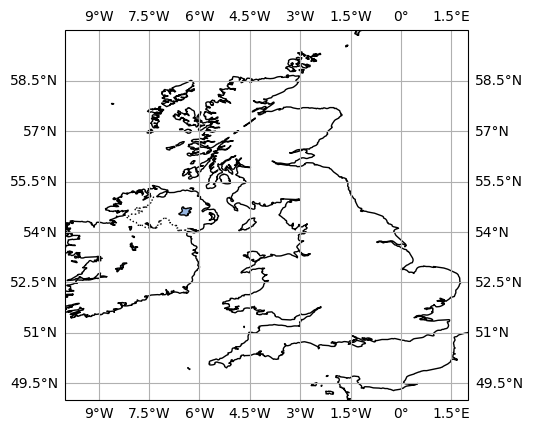

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_uk_border():
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 2, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 显示图像
    plt.show()

plot_uk_border()


### original asos station tempreature  average

In [24]:
# station_info_path = "F:\JuPyterNotebook\irp_ww721_bakcup\data\processed_data\ASOS_DATA\GB_ASOS_DATA\GB_merged_ASOS_2022.csv"

In [32]:
station_info_path ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_2022.csv"

In [33]:
df = pd.read_csv(station_info_path)
df

latitude  longitude                 time    t2m
0        57.2049    -2.2053  2022-01-01 00:00:00  279.2
1        57.2049    -2.2053  2022-01-01 01:00:00  282.2
2        57.2049    -2.2053  2022-01-01 02:00:00  282.2
3        57.2049    -2.2053  2022-01-01 03:00:00  283.2
4        57.2049    -2.2053  2022-01-01 04:00:00  283.2
...          ...        ...                  ...    ...
626903   53.3943    -1.3885  2022-12-31 19:00:00  283.2
626904   53.3943    -1.3885  2022-12-31 20:00:00  283.2
626905   53.3943    -1.3885  2022-12-31 21:00:00  283.2
626906   53.3943    -1.3885  2022-12-31 22:00:00  284.2
626907   53.3943    -1.3885  2022-12-31 23:00:00  283.2

[626908 rows x 4 columns]

In [34]:

# 计算每个观测站的温度均值
temperature_mean_by_station = df.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

# 打印结果
print(temperature_mean_by_station)


    latitude  longitude         t2m
0    50.0843    -5.2571  285.179590
1    50.1028    -5.6706  286.233314
2    50.4406    -4.9954  285.655167
3    50.7372    -3.4058  286.027510
4    50.7794    -1.8362  286.209625
..       ...        ...         ...
77   57.2049    -2.2053  282.578240
78   57.5425    -4.0475  282.588366
79   57.6456    -3.5635  282.900118
80   57.7114    -3.3235  282.786196
81   57.8249    -3.9555  284.323108

[82 rows x 3 columns]


In [35]:
temperature_mean_by_station

latitude  longitude         t2m
0    50.0843    -5.2571  285.179590
1    50.1028    -5.6706  286.233314
2    50.4406    -4.9954  285.655167
3    50.7372    -3.4058  286.027510
4    50.7794    -1.8362  286.209625
..       ...        ...         ...
77   57.2049    -2.2053  282.578240
78   57.5425    -4.0475  282.588366
79   57.6456    -3.5635  282.900118
80   57.7114    -3.3235  282.786196
81   57.8249    -3.9555  284.323108

[82 rows x 3 columns]

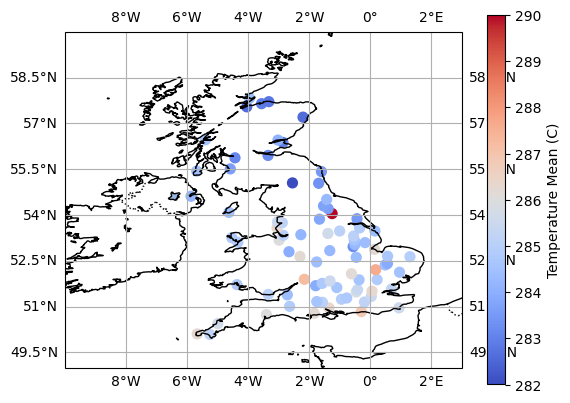

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_uk_with_temperatures(temperature_mean, latitudes, longitudes,vmin=282,vmax=290):
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 3, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 在地图上绘制温度均值
    scatter_size = 50  # Modify this value to adjust point size
#     vmin = temperature_mean.min()  # Minimum value for color mapping
#     vmax = temperature_mean.max()  # Maximum value for color mapping
#     vmin = 282
#     vmax = 290
    plt.scatter(longitudes, latitudes, c=temperature_mean, s=scatter_size, cmap='coolwarm', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
#     plt.scatter(longitudes, latitudes, c=temperature_mean, s=scatter_size, cmap='coolwarm', transform=ccrs.PlateCarree())
    
    plt.colorbar(label='Temperature Mean (C)')
    
    # 显示图像
    plt.show()

# 假设latitudes和longitudes是观测站的纬度和经度数组
plot_uk_with_temperatures(temperature_mean_by_station['t2m'], temperature_mean_by_station['latitude'], temperature_mean_by_station['longitude'])


### plot_krige average

In [37]:
output_path ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/da_test_data/2022_data/GB_2022_data/asos_kridge_2022.nc" # poly

In [38]:
output_path2 ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/da_test_data/2022_data/GB_2022_data/asos_kridge_2022_2.nc" #north

In [39]:
ds2 = xr.open_dataset(output_path2)
ds2

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64, time: 8760)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [42]:
ds=xr.open_dataset(output_path)
ds

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64, time: 8760)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...

In [40]:
average_temperatures2 = ds2["t2m"].mean(dim="time").to_dataframe().reset_index()

In [43]:
average_temperatures = ds["t2m"].mean(dim="time").to_dataframe().reset_index()

In [44]:
# 打印结果
print(average_temperatures2.head(50))

    latitude  longitude         t2m
0       50.0     -6.000  285.201080
1       50.0     -5.875  285.412201
2       50.0     -5.750  285.186462
3       50.0     -5.625  285.322144
4       50.0     -5.500  285.198395
5       50.0     -5.375  285.214233
6       50.0     -5.250  285.188293
7       50.0     -5.125  285.052155
8       50.0     -5.000  285.152618
9       50.0     -4.875  284.785858
10      50.0     -4.750  285.101593
11      50.0     -4.625  284.576385
12      50.0     -4.500  285.042999
13      50.0     -4.375  284.658600
14      50.0     -4.250  284.983551
15      50.0     -4.125  284.830658
16      50.0     -4.000  284.925018
17      50.0     -3.875  284.805573
18      50.0     -3.750  284.869781
19      50.0     -3.625  284.575684
20      50.0     -3.500  284.819489
21      50.0     -3.375  284.376831
22      50.0     -3.250  284.768646
23      50.0     -3.125  284.258911
24      50.0     -3.000  284.716400
25      50.0     -2.875  284.268585
26      50.0     -2.750  284

In [45]:
# 打印结果
print(average_temperatures.head(50))

    latitude  longitude         t2m
0       50.0     -6.000  285.409943
1       50.0     -5.875  285.280273
2       50.0     -5.750  285.412750
3       50.0     -5.625  285.219971
4       50.0     -5.500  285.442780
5       50.0     -5.375  285.143280
6       50.0     -5.250  285.445282
7       50.0     -5.125  285.012695
8       50.0     -5.000  285.423584
9       50.0     -4.875  284.769653
10      50.0     -4.750  285.380798
11      50.0     -4.625  284.568665
12      50.0     -4.500  285.330536
13      50.0     -4.375  284.647858
14      50.0     -4.250  285.275848
15      50.0     -4.125  284.818359
16      50.0     -4.000  285.219330
17      50.0     -3.875  284.788330
18      50.0     -3.750  285.164429
19      50.0     -3.625  284.559570
20      50.0     -3.500  285.109375
21      50.0     -3.375  284.367004
22      50.0     -3.250  285.053925
23      50.0     -3.125  284.245026
24      50.0     -3.000  284.992645
25      50.0     -2.875  284.252350
26      50.0     -2.750  284

In [46]:
# 打印结果
average_temperatures2

latitude  longitude         t2m
0        50.00     -6.000  285.201080
1        50.00     -5.875  285.412201
2        50.00     -5.750  285.186462
3        50.00     -5.625  285.322144
4        50.00     -5.500  285.198395
...        ...        ...         ...
2043     57.75      1.375  282.910614
2044     57.75      1.500  282.631836
2045     57.75      1.625  282.815277
2046     57.75      1.750  282.639893
2047     57.75      1.875  282.722931

[2048 rows x 3 columns]

In [47]:
average_temperatures

latitude  longitude         t2m
0        50.00     -6.000  285.409943
1        50.00     -5.875  285.280273
2        50.00     -5.750  285.412750
3        50.00     -5.625  285.219971
4        50.00     -5.500  285.442780
...        ...        ...         ...
2043     57.75      1.375  283.326630
2044     57.75      1.500  282.603912
2045     57.75      1.625  283.227692
2046     57.75      1.750  282.596588
2047     57.75      1.875  283.128998

[2048 rows x 3 columns]

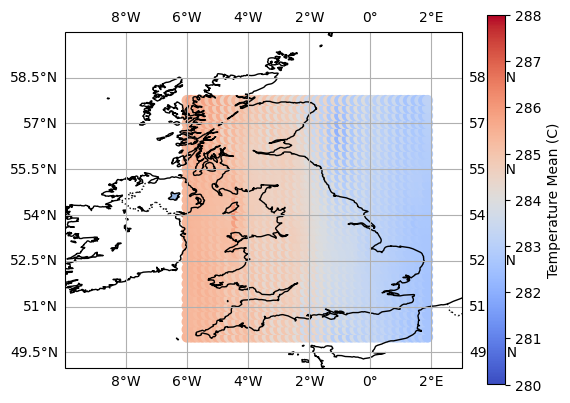

In [48]:
plot_uk_with_temperatures(average_temperatures['t2m'], average_temperatures['latitude'], average_temperatures['longitude'],vmin = 280.,vmax=288)
# poly

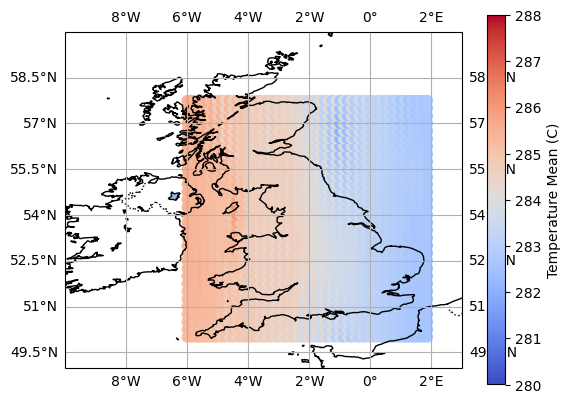

In [49]:
plot_uk_with_temperatures(average_temperatures2['t2m'], average_temperatures2['latitude'], average_temperatures2['longitude'],vmin = 280.,vmax=288)
# north

### era5_plot

In [50]:
output_path ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/da_test_data/2022_data/GB_2022_data/era5_pressure_level_2022_regrid_filter_850.nc"

In [51]:
ds3=xr.open_dataset(output_path)
ds3

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
Data variables:
    t        (time, lat, lon) float32 ...
Attributes:
    regrid_method:  bilinear
    Conventions:    CF-1.6
    history:        2023-08-26 19:02:51 GMT by grib_to_netcdf-2.25.1: /opt/ec...

In [53]:
average_temperatures3 = ds3["t"].mean(dim="time").to_dataframe().reset_index()

In [54]:
print(average_temperatures3.head(50))

     lat    lon           t
0   50.0 -6.000  277.038391
1   50.0 -5.875  277.036316
2   50.0 -5.750  277.034271
3   50.0 -5.625  277.020325
4   50.0 -5.500  277.006317
5   50.0 -5.375  277.002075
6   50.0 -5.250  276.997498
7   50.0 -5.125  276.998413
8   50.0 -5.000  276.999634
9   50.0 -4.875  277.006744
10  50.0 -4.750  277.012207
11  50.0 -4.625  277.012756
12  50.0 -4.500  277.015564
13  50.0 -4.375  277.019806
14  50.0 -4.250  277.023285
15  50.0 -4.125  277.018982
16  50.0 -4.000  277.014587
17  50.0 -3.875  277.018188
18  50.0 -3.750  277.020294
19  50.0 -3.625  277.032379
20  50.0 -3.500  277.044342
21  50.0 -3.375  277.043457
22  50.0 -3.250  277.044006
23  50.0 -3.125  277.051300
24  50.0 -3.000  277.060150
25  50.0 -2.875  277.060791
26  50.0 -2.750  277.062622
27  50.0 -2.625  277.071411
28  50.0 -2.500  277.080994
29  50.0 -2.375  277.079895
30  50.0 -2.250  277.078552
31  50.0 -2.125  277.091766
32  50.0 -2.000  277.104645
33  50.0 -1.875  277.105713
34  50.0 -1.750  277

In [55]:
average_temperatures3

lat    lon           t
0     50.00 -6.000  277.038391
1     50.00 -5.875  277.036316
2     50.00 -5.750  277.034271
3     50.00 -5.625  277.020325
4     50.00 -5.500  277.006317
...     ...    ...         ...
2043  57.75  1.375  274.762848
2044  57.75  1.500  274.756714
2045  57.75  1.625  274.745331
2046  57.75  1.750  274.733307
2047  57.75  1.875  274.733307

[2048 rows x 3 columns]

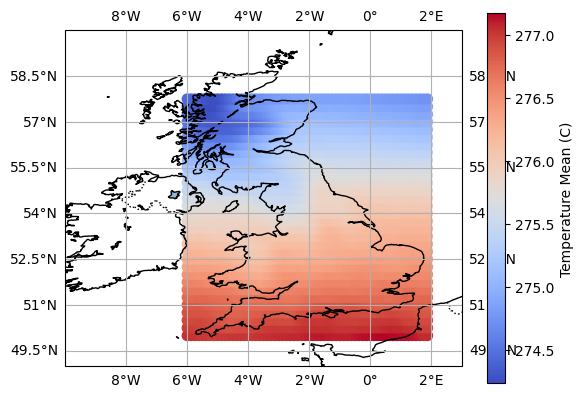

In [58]:
plot_uk_with_temperatures_2(average_temperatures3['t'], average_temperatures3['lat'], average_temperatures3['lon'])


## select oneday

### select asos

In [136]:
# 假设你的DataFrame中包含的列名是 "latitude"、"longitude"、"time" 和 "t2m"
# 选择特定时间点的数据
selected_time = "2022-06-15 12:00:00"
selected_data = df[df["time"] == selected_time]

In [137]:
selected_data 


latitude  longitude                 time    t2m
3971     57.2049    -2.2053  2022-06-15 12:00:00  292.2
12999    53.2527    -4.5365  2022-06-15 12:00:00  290.2
18531    52.9622    -0.5616  2022-06-15 12:00:00    NaN
26616    54.6135    -5.8735  2022-06-15 12:00:00  293.2
35682    51.6202    -1.0987  2022-06-15 12:00:00  297.2
...          ...        ...                  ...    ...
597113   52.1239     0.9573  2022-06-15 12:00:00  295.2
606072   52.6114    -0.4612  2022-06-15 12:00:00  296.2
611555   53.5816    -3.0555  2022-06-15 12:00:00  292.2
617219   51.0063    -2.6428  2022-06-15 12:00:00  295.2
623730   53.3943    -1.3885  2022-06-15 12:00:00  291.2

[76 rows x 4 columns]

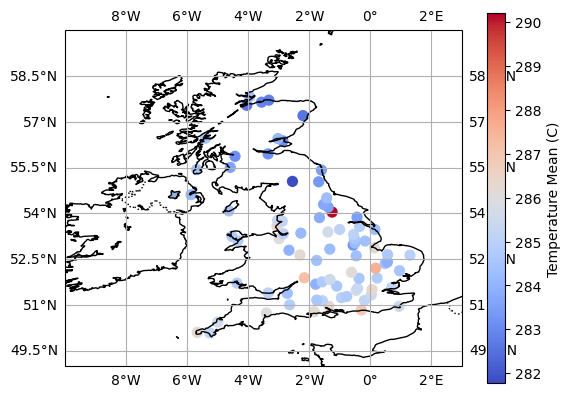

In [57]:
def plot_uk_with_temperatures_2(temperature_mean, latitudes, longitudes):
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 3, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 在地图上绘制温度均值
    scatter_size = 50  # Modify this value to adjust point size
#     vmin = temperature_mean.min()  # Minimum value for color mapping
#     vmax = temperature_mean.max()  # Maximum value for color mapping
#     vmin = 282
#     vmax = 290
    plt.scatter(longitudes, latitudes, c=temperature_mean, s=scatter_size, cmap='coolwarm', transform=ccrs.PlateCarree())
#     plt.scatter(longitudes, latitudes, c=temperature_mean, s=scatter_size, cmap='coolwarm', transform=ccrs.PlateCarree())
    
    plt.colorbar(label='Temperature Mean (C)')
    
    # 显示图像
    plt.show()

# 假设latitudes和longitudes是观测站的纬度和经度数组
plot_uk_with_temperatures_2(temperature_mean_by_station['t2m'], temperature_mean_by_station['latitude'], temperature_mean_by_station['longitude'])

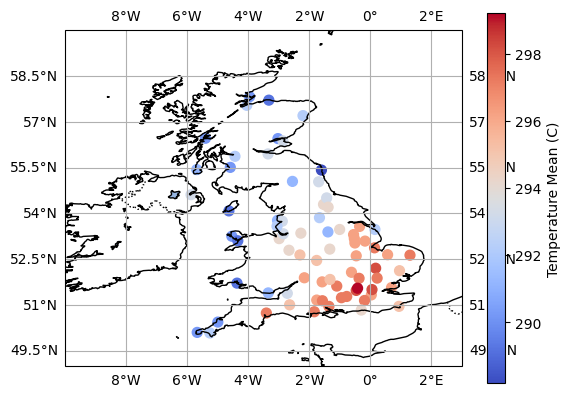

In [139]:
plot_uk_with_temperatures_2(selected_data["t2m"],selected_data["latitude"],selected_data["longitude"])

###  ds_select_poly_kridge

In [59]:
selected_time = "2022-01-01 00:00:00"
selected_data = ds.sel(time=selected_time)
selected_data #poly

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
    time       datetime64[ns] 2022-01-01
Data variables:
    t2m        (latitude, longitude) float32 285.8 286.8 285.6 ... 279.5 276.8

In [60]:
# 提取所需的信息
selected_latitudes = selected_data["latitude"].values
selected_longitudes = selected_data["longitude"].values
selected_temperatures = selected_data["t2m"].values

# 打印结果
print(selected_latitudes)
print(selected_longitudes)
print(selected_temperatures)

[50.   50.25 50.5  50.75 51.   51.25 51.5  51.75 52.   52.25 52.5  52.75
 53.   53.25 53.5  53.75 54.   54.25 54.5  54.75 55.   55.25 55.5  55.75
 56.   56.25 56.5  56.75 57.   57.25 57.5  57.75]
[-6.    -5.875 -5.75  -5.625 -5.5   -5.375 -5.25  -5.125 -5.    -4.875
 -4.75  -4.625 -4.5   -4.375 -4.25  -4.125 -4.    -3.875 -3.75  -3.625
 -3.5   -3.375 -3.25  -3.125 -3.    -2.875 -2.75  -2.625 -2.5   -2.375
 -2.25  -2.125 -2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125
 -1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125
  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375
  1.5    1.625  1.75   1.875]
[[285.76486 286.75388 285.62247 ... 279.38367 277.57    279.38773]
 [285.83807 286.72784 285.6694  ... 279.3199  277.58795 279.28244]
 [285.91324 286.69766 285.71182 ... 279.2686  277.60025 279.18762]
 ...
 [286.80142 284.66632 286.85178 ... 277.47018 279.77713 277.01422]
 [286.79123 284.54694 286.83655 ... 277.36157 279.6346  276.9032 ]
 [286.77

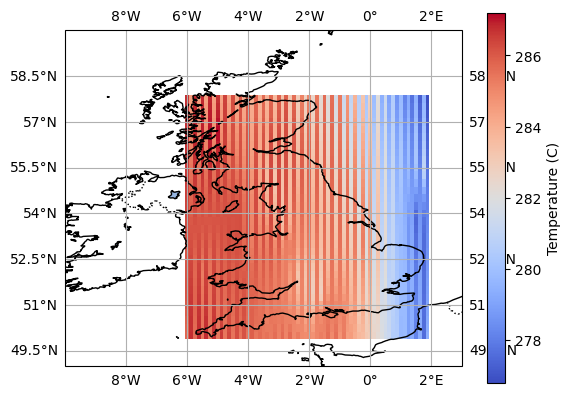

In [61]:
def plot_selected_temperatures_3(temperature_data, latitudes, longitudes):
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 3, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 在地图上绘制温度值
    im = plt.pcolormesh(longitudes, latitudes, temperature_data, cmap='coolwarm', transform=ccrs.PlateCarree())
    
    plt.colorbar(im, label='Temperature (C)')
    
    # 显示图像
    plt.show()

# 使用 selected_data 中的温度值、纬度和经度
temperature_data = selected_data["t2m"].values
latitudes = selected_data["latitude"].values
longitudes = selected_data["longitude"].values

plot_selected_temperatures_3(temperature_data, latitudes, longitudes)


In [126]:
# 假设你的xarray数据集的时间坐标为 "time"，经纬度坐标为 "lat" 和 "lon"
# 选择特定时间点的数据
selected_time = "2022-08-15 12:00:00"
selected_data = ds.sel(time=selected_time)

# 提取所需的信息
selected_latitudes = selected_data["latitude"].values
selected_longitudes = selected_data["longitude"].values
selected_temperatures = selected_data["t2m"].values

# 打印结果
print(selected_latitudes.shape)
print(selected_longitudes.shape)
print(selected_temperatures.shape)


(32,)
(64,)
(32, 64)


### ds_2 plot_one_day_north

In [63]:
selected_time = "2022-01-01 00:00:00"
selected_data = ds2.sel(time=selected_time)
selected_data #north

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
    time       datetime64[ns] 2022-01-01
Data variables:
    t2m        (latitude, longitude) float32 286.3 286.9 286.0 ... 279.8 279.4

In [64]:
# 提取所需的信息
selected_latitudes = selected_data["latitude"].values
selected_longitudes = selected_data["longitude"].values
selected_temperatures = selected_data["t2m"].values

# 打印结果
print(selected_latitudes)
print(selected_longitudes)
print(selected_temperatures)

[50.   50.25 50.5  50.75 51.   51.25 51.5  51.75 52.   52.25 52.5  52.75
 53.   53.25 53.5  53.75 54.   54.25 54.5  54.75 55.   55.25 55.5  55.75
 56.   56.25 56.5  56.75 57.   57.25 57.5  57.75]
[-6.    -5.875 -5.75  -5.625 -5.5   -5.375 -5.25  -5.125 -5.    -4.875
 -4.75  -4.625 -4.5   -4.375 -4.25  -4.125 -4.    -3.875 -3.75  -3.625
 -3.5   -3.375 -3.25  -3.125 -3.    -2.875 -2.75  -2.625 -2.5   -2.375
 -2.25  -2.125 -2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125
 -1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125
  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375
  1.5    1.625  1.75   1.875]
[[286.25427 286.90836 286.0033  ... 279.5597  278.78085 279.72287]
 [286.24817 286.8942  285.9765  ... 279.53497 278.71426 279.658  ]
 [286.24606 286.87656 285.9482  ... 279.5249  278.64438 279.60568]
 ...
 [286.92368 285.96918 286.89618 ... 279.66223 280.00348 279.4202 ]
 [286.9237  285.94824 286.8891  ... 279.66003 279.89514 279.41745]
 [286.91

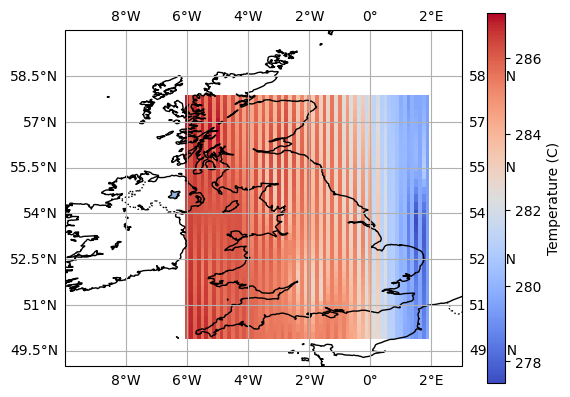

In [65]:
def plot_selected_temperatures_3(temperature_data, latitudes, longitudes):
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 3, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 在地图上绘制温度值
    im = plt.pcolormesh(longitudes, latitudes, temperature_data, cmap='coolwarm', transform=ccrs.PlateCarree())
    
    plt.colorbar(im, label='Temperature (C)')
    
    # 显示图像
    plt.show()

# 使用 selected_data 中的温度值、纬度和经度
temperature_data = selected_data["t2m"].values
latitudes = selected_data["latitude"].values
longitudes = selected_data["longitude"].values

plot_selected_temperatures_3(temperature_data, latitudes, longitudes)


In [126]:
# 假设你的xarray数据集的时间坐标为 "time"，经纬度坐标为 "lat" 和 "lon"
# 选择特定时间点的数据
selected_time = "2022-08-15 12:00:00"
selected_data = ds.sel(time=selected_time)

# 提取所需的信息
selected_latitudes = selected_data["latitude"].values
selected_longitudes = selected_data["longitude"].values
selected_temperatures = selected_data["t2m"].values

# 打印结果
print(selected_latitudes.shape)
print(selected_longitudes.shape)
print(selected_temperatures.shape)


(32,)
(64,)
(32, 64)


### era5_select_plot_one_day

In [66]:
selected_time = "2022-01-01 00:00:00"
selected_data = ds3.sel(time=selected_time)
selected_data

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    time     datetime64[ns] 2022-01-01
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
Data variables:
    t        (lat, lon) float32 286.3 286.2 286.0 285.8 ... 276.7 276.7 276.7
Attributes:
    regrid_method:  bilinear
    Conventions:    CF-1.6
    history:        2023-08-26 19:02:51 GMT by grib_to_netcdf-2.25.1: /opt/ec...

In [68]:
# 提取所需的信息
selected_latitudes = selected_data["lat"].values
selected_longitudes = selected_data["lon"].values
selected_temperatures = selected_data["t"].values

# 打印结果
print(selected_latitudes)
print(selected_longitudes)
print(selected_temperatures)

[50.   50.25 50.5  50.75 51.   51.25 51.5  51.75 52.   52.25 52.5  52.75
 53.   53.25 53.5  53.75 54.   54.25 54.5  54.75 55.   55.25 55.5  55.75
 56.   56.25 56.5  56.75 57.   57.25 57.5  57.75]
[-6.    -5.875 -5.75  -5.625 -5.5   -5.375 -5.25  -5.125 -5.    -4.875
 -4.75  -4.625 -4.5   -4.375 -4.25  -4.125 -4.    -3.875 -3.75  -3.625
 -3.5   -3.375 -3.25  -3.125 -3.    -2.875 -2.75  -2.625 -2.5   -2.375
 -2.25  -2.125 -2.    -1.875 -1.75  -1.625 -1.5   -1.375 -1.25  -1.125
 -1.    -0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125  0.     0.125
  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125  1.25   1.375
  1.5    1.625  1.75   1.875]
[[286.3373  286.1772  286.0171  ... 282.1449  282.13416 282.13416]
 [286.34314 286.18207 286.021   ... 282.29343 282.2574  282.2574 ]
 [286.39423 286.2232  286.0522  ... 282.52975 282.52298 282.52298]
 ...
 [277.40567 277.35794 277.3101  ... 276.81894 276.7828  276.7828 ]
 [277.1888  277.20172 277.21454 ... 276.7497  276.74576 276.74576]
 [276.89

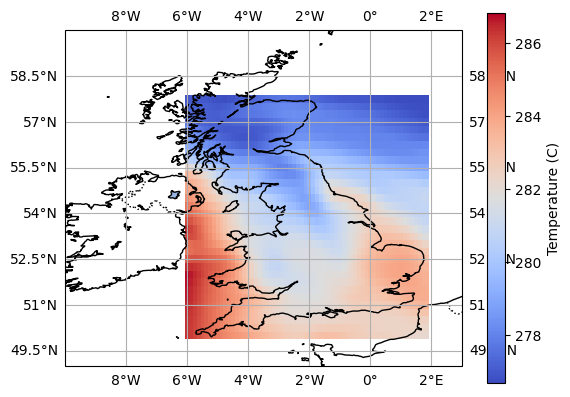

In [70]:
def plot_selected_temperatures_3(temperature_data, latitudes, longitudes):
    # 创建一个matplotlib的图和坐标轴，使用PlateCarree投影
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    
    # 设置地理范围为英国周边
    ax.set_extent([-10, 3, 49, 60], crs=ccrs.PlateCarree())
    
    # 添加英国的边界
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # 添加海岸线和湖泊
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    
    # 添加网格线
    ax.gridlines(draw_labels=True)
    
    # 在地图上绘制温度值
    im = plt.pcolormesh(longitudes, latitudes, temperature_data, cmap='coolwarm', transform=ccrs.PlateCarree())
    
    plt.colorbar(im, label='Temperature (C)')
    
    # 显示图像
    plt.show()

# 使用 selected_data 中的温度值、纬度和经度
temperature_data = selected_data["t"].values
latitudes = selected_data["lat"].values
longitudes = selected_data["lon"].values

plot_selected_temperatures_3(temperature_data, latitudes, longitudes)


In [126]:
# 假设你的xarray数据集的时间坐标为 "time"，经纬度坐标为 "lat" 和 "lon"
# 选择特定时间点的数据
selected_time = "2022-08-15 12:00:00"
selected_data = ds.sel(time=selected_time)

# 提取所需的信息
selected_latitudes = selected_data["latitude"].values
selected_longitudes = selected_data["longitude"].values
selected_temperatures = selected_data["t2m"].values

# 打印结果
print(selected_latitudes.shape)
print(selected_longitudes.shape)
print(selected_temperatures.shape)


(32,)
(64,)
(32, 64)


## coarse version 

In [ ]:
import geopandas as gpd

def download_uk_border():
    # 从Natural Earth下载全球国家边界数据
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # 提取英国的边界数据
    uk = world[world['name'] == "United Kingdom"]

    # 保存英国的边界到Shapefile
    uk.to_file("UK_border.shp")

download_uk_border()


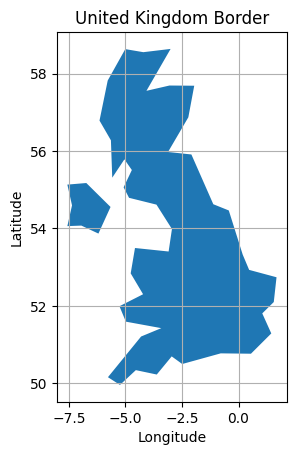

In [125]:
# 从Shapefile加载英国的边界数据
uk_border = gpd.read_file("UK_border.shp")

# 绘制并显示边界
uk_border.plot()
plt.title("United Kingdom Border")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [126]:
gdf = gpd.read_file('UK_border.shp')

In [127]:
gdf

pop_est continent            name iso_a3  gdp_md_est  \
0  66834405.0    Europe  United Kingdom    GBR     2829108   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 geometry  
0  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54.07370, -7.57217 54.05996, -7.36603 54.59584, -7.57217 55.13162, -6.73385 55.17286, -5.66195 54.55460, -6.19788 53.86757)), ((-3.09383 53.40455, -3.09208 53.40444, -2.94501 53.98500, -3.61470 54.60094, -3.63001 54.61501, -4.84417 54.79097, -5.08253 55.06160, -4.71911 55.50847, -5.04798 55.78399, -5.58640 55.31115, -5.64500 56.27501, -6.14998 56.78501, -5.78682 57.81885, -5.01000 58.63001, -4.21149 58.55085, -3.00500 58.63500, -4.07383 57.55302, -3.05500 57.69002, -1.95928 57.68480, -2.21999 56.87002, -3.11900 55.97379, -2.08501 55.91000, -2.00568 55.80490, -1.11499 54.62499, -0.43048 54.46438, 0.18498 53.32501, 0.46998 52.93000, 1.68153 52.73952, 1.55999 52.10000, 1.05056 51.80676, 1.44987 51.28943, 0.55033 50.76574, -0.78752 50.77499, -2.49000 50.50002, -2.95627 50.69688, -3.61745 50.22836, -4.54251 50.34184, -5.24502 49.96000, -5.77657 50.15968, -4.30999 51.21000, -3.41485 51.42601, -3.42272 51.42685, -4.98437 51.59347, -5.26730 51.99140, -4.22235 52.30136, -4.77001 52.84000, -4.58000 53.49500, -3.09383 53.40455)))

## Regrid

### test1

In [129]:
gridx = np.linspace(-6.0, 1.875, 64)

In [130]:
gridx

array([-6.   , -5.875, -5.75 , -5.625, -5.5  , -5.375, -5.25 , -5.125,
       -5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375, -4.25 , -4.125,
       -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375, -3.25 , -3.125,
       -3.   , -2.875, -2.75 , -2.625, -2.5  , -2.375, -2.25 , -2.125,
       -2.   , -1.875, -1.75 , -1.625, -1.5  , -1.375, -1.25 , -1.125,
       -1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
        0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875])

In [133]:
gridy = np.linspace(50.0, 57.75, 32) 

In [134]:
gridy

array([50.  , 50.25, 50.5 , 50.75, 51.  , 51.25, 51.5 , 51.75, 52.  ,
       52.25, 52.5 , 52.75, 53.  , 53.25, 53.5 , 53.75, 54.  , 54.25,
       54.5 , 54.75, 55.  , 55.25, 55.5 , 55.75, 56.  , 56.25, 56.5 ,
       56.75, 57.  , 57.25, 57.5 , 57.75])

### test2

#### basic import

In [3]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import gstools as gs
import geopandas as gpd
import matplotlib.pyplot as plt
from utils import folder_utils
from tqdm import tqdm

In [14]:
def filter_data(df):
    """
    Filter data by deleting rows with missing values and wrong values
    """
    # Delete rows with missing values
    df = df.dropna()
    # Delete rows with wrong values
    df["time"] = pd.to_datetime(df["time"])  # Convert to datetime
    # If the time is not a whole hour, delete the row
    is_whole_hour = (df["time"].dt.minute == 0) & (df["time"].dt.second == 0)
    not_null = df["time"].notnull()
    latitude_condition = (df["latitude"] >= 50) & (df["latitude"] <= 58)
    longitude_condition = (df["longitude"] >= -6) & (df["longitude"] <= 2)
    # Combine all conditions
    combined_condition = (
        is_whole_hour & not_null & latitude_condition & longitude_condition
    )

    filtered_df = df[combined_condition]

    return filtered_df

In [165]:
def krige_regrid_poly(
    year_df_path, year, country, data_folder, data_category, output_folder
):
    # 1. Load the data
    df = pd.read_csv(year_df_path)
    df = filter_data(df)
    # lat = df["latitude"].values
    # lon = df["longitude"].values

    # 2. Create a new dataframe to store the interpolated data
    output_df = pd.DataFrame()

    # 3.Define the grid
    g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
    g_lat = np.linspace(50.0, 57.75, 32)  # latitude
    # gridx, gridy = np.meshgrid(gridx, gridy)

    # 4. Drift term
    def north_south_drift(lat, lon):
        return lat
    
        # 4. Drift term
    def polynomial_drift(lat, lon):
        return [1, lat, lon, lat**2, lon**2, lat*lon]
    
        # 4. Drift terms
    def drift_1(lat, lon):
        return 1

    def drift_lat(lat, lon):
        return lat

    def drift_lon(lat, lon):
        return lon

    def drift_lat2(lat, lon):
        return lat**2

    def drift_lon2(lat, lon):
        return lon**2

    def drift_lat_lon(lat, lon):
        return lat*lon

    drift_functions = [drift_1, drift_lat, drift_lon, drift_lat2, drift_lon2, drift_lat_lon]

    unique_times = df["time"].unique()

    # Iterate over each time
    for time_point in tqdm(unique_times):
        # 1. Load data for the specific time point
        time_df = df[df["time"] == time_point]
        t2m = time_df["t2m"].values
        lat = time_df["latitude"].values
        lon = time_df["longitude"].values

        # 2. Estimate the variogram
        bin_center, vario = gs.vario_estimate(
            (lat, lon), t2m, latlon=True, geo_scale=gs.KM_SCALE, max_dist=900
        )

        # 3. krige interpolation
        model = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
        model.fit_variogram(bin_center, vario, nugget=False)

        # 5. Universal Kriging

        uk = gs.krige.Universal(
            model=model,
            cond_pos=(lat, lon),
            cond_val=t2m,
            drift_functions=drift_functions,
        )

        uk.set_pos((g_lat, g_lon), mesh_type="structured")
        interpolated_values = uk(return_var=False)

        temp_df = pd.DataFrame(
            {
                "lat": np.tile(g_lat, len(g_lon)),
                "lon": np.repeat(g_lon, len(g_lat)),
                "time": [time_point] * len(g_lat) * len(g_lon),
                "t2m": interpolated_values.ravel(),
            }
        )

        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    # Save to csv file
    output_directory = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    output_filename = f"{country}_ASOS_krige_{year}.csv"
    output_path = os.path.join(output_directory, output_filename)
    output_df.to_csv(output_path, index=False)

    # return output_df

In [155]:
def get_year(start_year, end_year):
    # start_year = 1979
    # end_year = 2023
    year_list = list(range(start_year, end_year + 1))

    # Convert the integer list to a string list
    year_str_list = [str(year) for year in year_list]

    return year_str_list


def get_year_from_filename(filename):
    # extract year from filename
    # filename = "GB_merged_ASOS_1979.csv"
    parts = filename.split("_")
    return parts[3]


def get_asos_year_file_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    csv_files = [
        f
        for f in os.listdir(input_folder_path)
        if f.endswith(".csv") and "_merged_ASOS_" in f
    ]

    # sort by year
    csv_files.sort(key=lambda x: get_year_from_filename(x))

    return [
        os.path.join(input_folder_path, csv_file) for csv_file in csv_files
    ]  # return the full path


#### example

In [156]:
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "raw_data"
data_test_category = "test_data"
data_save_category = "processed_data"
output_folder = "ASOS_DATA"

In [157]:
year_list = get_year(start_year=2022, end_year=2022)

In [158]:
csv_paths = get_asos_year_file_list(
    country, data_folder, data_save_category, output_folder
)

In [159]:
csv_paths

['/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1979.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1980.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1981.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1982.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1983.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1984.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_1985.csv',
 '/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakc

In [ ]:
for year, csv_path in tqdm(zip(year_list, csv_paths)):
    krige_regrid(csv_path, year, country, data_folder, data_save_category, output_folder)

0it [00:00, ?it/s]C:\Users\WWQ\AppData\Local\Temp\ipykernel_33960\2172439685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])  # Convert to datetime

 96%|██████████████████████████████████████████████████████████████████████████▊   | 8397/8760 [31:30<02:00,  3.01it/s]

 65%|██████████████████████████████████████████████████▋                           | 5706/8784 [17:10<12:44,  4.03it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 8767/8784 [33:57<00:06,  2.80it/s]D:\anaconda3\envs\da\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be

#### e2

In [160]:
test_path =csv_paths[-2]

In [162]:
test_path

'/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_merged_ASOS_2022.csv'

In [166]:
krige_regrid_poly(test_path, 2022, country, data_folder, data_save_category, output_folder)

/var/folders/tt/fs_l1by51m30s907pzxq6gf40000gp/T/ipykernel_5065/2172439685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_datetime(df["time"])  # Convert to datetime
100%|███████████████████████████████████████| 8760/8760 [24:26<00:00,  5.97it/s]


In [150]:
def krige_regrid(
    year_df_path, year, country, data_folder, data_category, output_folder
):
    # 1. Load the data
    df = pd.read_csv(year_df_path)
    df = filter_data(df)
    # lat = df["latitude"].values
    # lon = df["longitude"].values

    # 2. Create a new dataframe to store the interpolated data
    output_df = pd.DataFrame()

    # 3.Define the grid
    g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
    g_lat = np.linspace(50.0, 57.75, 32)  # latitude
    # gridx, gridy = np.meshgrid(gridx, gridy)

    # 4. Drift term
    def north_south_drift(lat, lon):
        return lat

    unique_times = df["time"].unique()

    # Iterate over each time
    for time_point in tqdm(unique_times):
        # 1. Load data for the specific time point
        time_df = df[df["time"] == time_point]
        t2m = time_df["t2m"].values
        lat = time_df["latitude"].values
        lon = time_df["longitude"].values

        # 2. Estimate the variogram
        bin_center, vario = gs.vario_estimate(
            (lat, lon), t2m, latlon=True, geo_scale=gs.KM_SCALE, max_dist=900
        )

        # 3. krige interpolation
        model = gs.Spherical(latlon=True, geo_scale=gs.KM_SCALE)
        model.fit_variogram(bin_center, vario, nugget=False)

        # 5. Universal Kriging

        uk = gs.krige.Universal(
            model=model,
            cond_pos=(lat, lon),
            cond_val=t2m,
            drift_functions=north_south_drift,
        )

        uk.set_pos((g_lat, g_lon), mesh_type="structured")
        interpolated_values = uk(return_var=False)

        temp_df = pd.DataFrame(
            {
                "lat": np.tile(g_lat, len(g_lon)),
                "lon": np.repeat(g_lon, len(g_lat)),
                "time": [time_point] * len(g_lat) * len(g_lon),
                "t2m": interpolated_values.ravel(),
            }
        )

        output_df = pd.concat([output_df, temp_df], ignore_index=True)

    # Save to csv file
    output_directory = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    output_filename = f"{country}_ASOS_krige_{year}.csv"
    output_path = os.path.join(output_directory, output_filename)
    output_df.to_csv(output_path, index=False)

    # return output_df

In [45]:
def csv_to_nc4(
    merged_csv_path, year, country, data_folder, data_category, output_folder
):
    """
    Convert csv files to nc4 files by year
    """
    # Read csv files
    df = pd.read_csv(merged_csv_path)

    # Filter data
    df = filter_data(df)

    ds_in = xr.Dataset.from_dataframe(df.set_index(["latitude", "longitude", "time"]))
    ds_in = ds_in.sel(latitude=slice(50, 58), longitude=slice(-6, 2))
    ds_adjusted = ds_in.transpose("time", "latitude", "longitude")
    ds_adjusted["t2m"] = ds_adjusted["t2m"].astype("float32")

    # ddeg_out_lat = 0.25
    # ddeg_out_lon = 0.125
    # regridded_ds = regrid(
    #     ds_in, ddeg_out_lat, ddeg_out_lon, method="bilinear", reuse_weights=False
    # )

    # Save to nc4 file

    output_directory = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    output_filename = f"{country}_ASOS_filter_{year}.nc"
    output_path = os.path.join(output_directory, output_filename)
    ds_adjusted.to_netcdf(output_path)
    print(f"{output_filename} done!")


## 2022 ASOS

In [4]:
df2 = pd.read_csv("/Users/ww721/JupyterNotebookPath/GB_ASOS_krige_2022.csv")

In [5]:
df = pd.read_csv("/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/processed_data/ASOS_DATA/GB_ASOS_DATA/GB_ASOS_krige_2022.csv")

In [ ]:
df

In [194]:
max(df2['t2m'].values)

313.6142070830105

In [6]:
max(df['t2m'].values)

313.6225632296596

In [7]:
ds_in_2 = xr.Dataset.from_dataframe(df2.set_index(["lat", "lon", "time"]))

In [8]:
ds_in = xr.Dataset.from_dataframe(df.set_index(["lat", "lon", "time"]))

In [9]:
ds_in

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * time     (time) object '2022-01-01 00:00:00' ... '2022-12-31 23:00:00'
Data variables:
    t2m      (lat, lon, time) float64 285.8 285.7 285.7 ... 279.2 281.9 281.4

In [10]:
ds_in["time"] = pd.to_datetime(ds_in["time"])

In [12]:
ds_in_2["time"] = pd.to_datetime(ds_in["time"])

In [13]:
ds

NameError: name 'ds' is not defined

In [14]:
ds_in

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m      (lat, lon, time) float64 285.8 285.7 285.7 ... 279.2 281.9 281.4

In [15]:
ds_adjusted = ds_in.transpose("time", "lat", "lon")
ds_adjusted["t2m"] = ds_adjusted["t2m"].astype("float32")

In [16]:
ds_adjusted2 = ds_in_2.transpose("time", "lat", "lon")
ds_adjusted2["t2m"] = ds_adjusted2["t2m"].astype("float32")

In [17]:
ds_adjusted

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 285.8 286.8 285.6 ... 281.6 276.0 281.4

In [18]:
ds_adjusted2

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 50.0 50.25 50.5 50.75 51.0 ... 57.0 57.25 57.5 57.75
  * lon      (lon) float64 -6.0 -5.875 -5.75 -5.625 ... 1.5 1.625 1.75 1.875
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 286.3 286.9 286.0 ... 277.0 275.7 276.7

In [19]:
new_coord_names = {
    'lat': 'latitude',
    'lon': 'longitude',
#     't2m':'t',
    
}
# 使用.rename()方法来重命名坐标
ds_adjusted2 = ds_adjusted2.rename(new_coord_names)

In [20]:
# 重命名数据变量
# new_variable_names = {
#     't2m': 't',
# }
# ds_adjusted = ds_adjusted.rename(new_variable_names)

# 重命名坐标
new_coord_names = {
    'lat': 'latitude',
    'lon': 'longitude',
#     't2m':'t',
    
}
# 使用.rename()方法来重命名坐标
ds_adjusted = ds_adjusted.rename(new_coord_names)

In [21]:
ds_adjusted2

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64, time: 8760)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 286.3 286.9 ... 275.7 276.7

In [22]:
ds_adjusted

<xarray.Dataset>
Dimensions:    (latitude: 32, longitude: 64, time: 8760)
Coordinates:
  * latitude   (latitude) float64 50.0 50.25 50.5 50.75 ... 57.25 57.5 57.75
  * longitude  (longitude) float64 -6.0 -5.875 -5.75 -5.625 ... 1.625 1.75 1.875
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 285.8 286.8 ... 276.0 281.4

In [23]:
# 保存修改后的数据集
output_path ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/da_test_data/asos_kridge_2022.nc"
ds_adjusted.to_netcdf(output_path)  # 将'new_dataset.nc'替换为新的文件名  # poly

In [24]:
output_path ="/Users/ww721/JupyterNotebookPath/IRP_20220602/irp_ww721_bakcup/data/da_test_data/asos_kridge_2022_2.nc"
ds_adjusted2.to_netcdf(output_path)  # 将'new_dataset.nc'替换为新的文件名 # north